# Experiment 6
## Object detection with single-stage and two-stage detectors (Yolo, SSD, Faster RCNN

Importing libraries

In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from google.colab.patches import cv2_imshow
# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.2
The following GPU devices are available: 


Image resizing and drawing bounding boxes


In [ ]:
def display_image(image):
  cv2_imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Loading Faster RCNN model from tensorflow hub

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
path = download_and_resize_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS1w-Bry-PX42X8tFiwIW9GER0t5kV8WDpGxA&usqp=CAU", 640, 480)
img = load_img(path)
converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
result = detector(converted_img)

Image downloaded to /tmp/tmpvkm8opm9.jpg.


In [ ]:
type(result)

dict

Detection function

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Model results 

Image downloaded to /tmp/tmpuvajaw8m.jpg.
Found 100 objects.
Inference time:  69.73528289794922


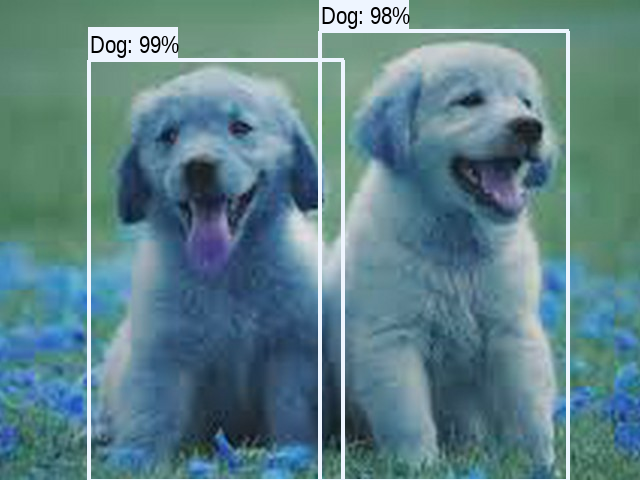

Inference time: 70.14842915534973
Image downloaded to /tmp/tmppw01vzyc.jpg.
Found 100 objects.
Inference time:  30.938498973846436


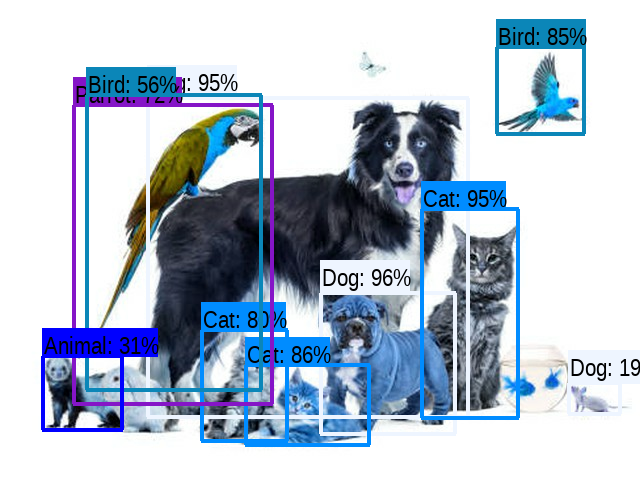

Inference time: 31.148301124572754
Image downloaded to /tmp/tmp5tmateo0.jpg.
Found 100 objects.
Inference time:  31.57625150680542


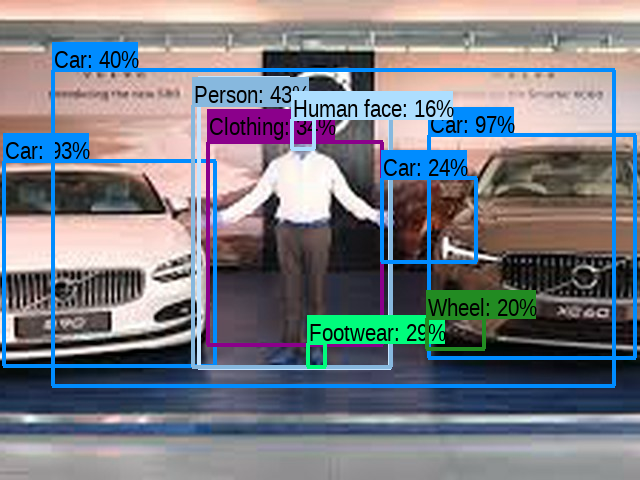

Inference time: 31.81130814552307
Image downloaded to /tmp/tmpge4nsg5d.jpg.
Found 100 objects.
Inference time:  30.50357222557068


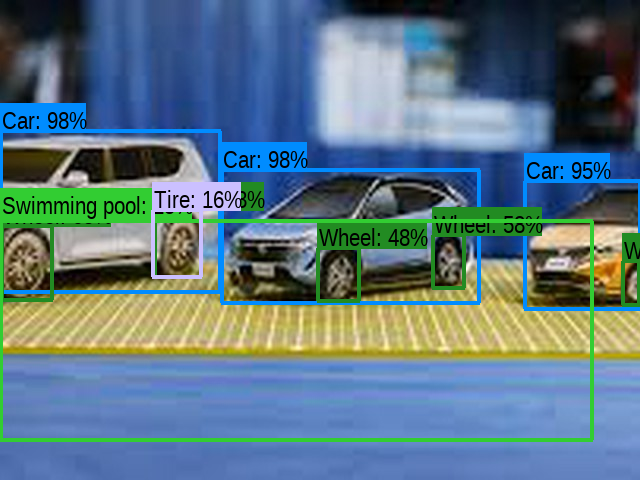

Inference time: 30.73664093017578
Image downloaded to /tmp/tmptpd5lfhs.jpg.
Found 100 objects.
Inference time:  31.158592462539673


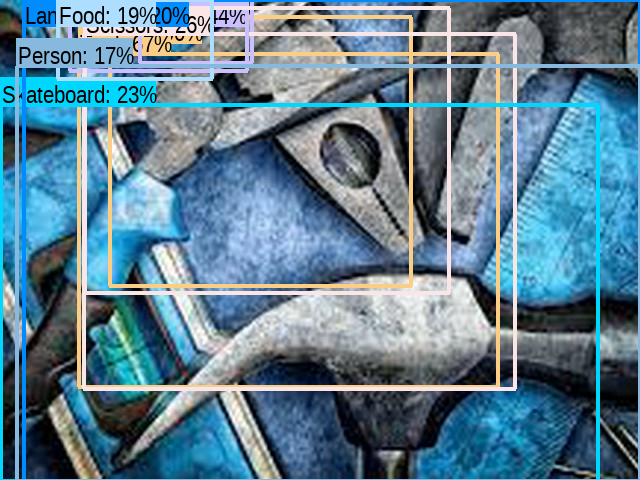

Inference time: 31.41095757484436
Image downloaded to /tmp/tmpa733lgn_.jpg.
Found 100 objects.
Inference time:  31.848013162612915


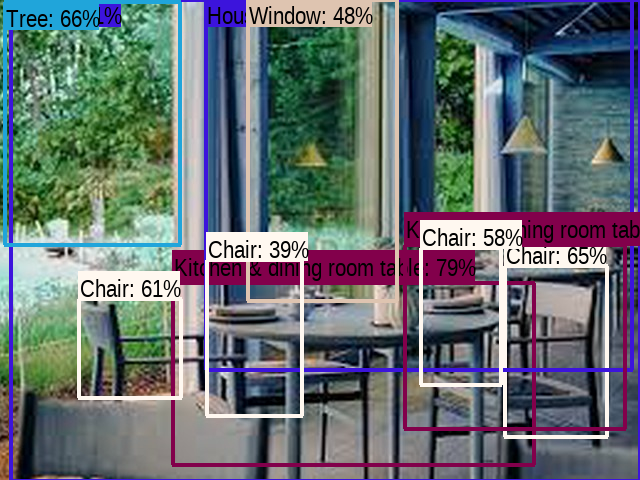

Inference time: 32.11862373352051
Image downloaded to /tmp/tmplb9lomsj.jpg.
Found 100 objects.
Inference time:  31.01529335975647


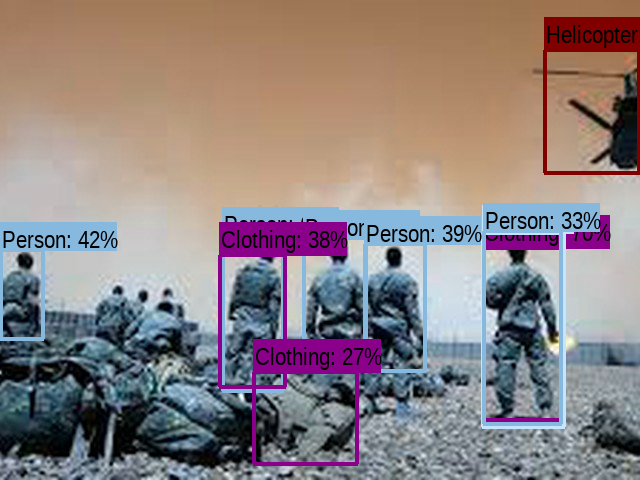

Inference time: 31.226874351501465
Image downloaded to /tmp/tmpzq2z2hwa.jpg.
Found 100 objects.
Inference time:  31.714502811431885


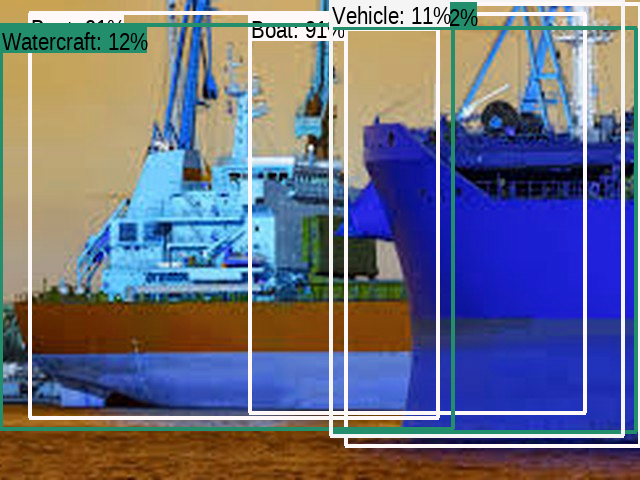

Inference time: 31.926626443862915
Image downloaded to /tmp/tmpc_kfnfj9.jpg.
Found 100 objects.
Inference time:  30.592588186264038


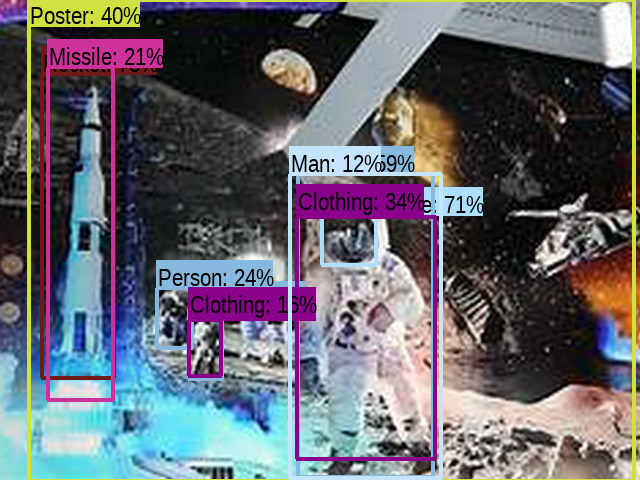

Inference time: 30.943561553955078
Image downloaded to /tmp/tmprzp62w13.jpg.
Found 100 objects.
Inference time:  30.834513664245605


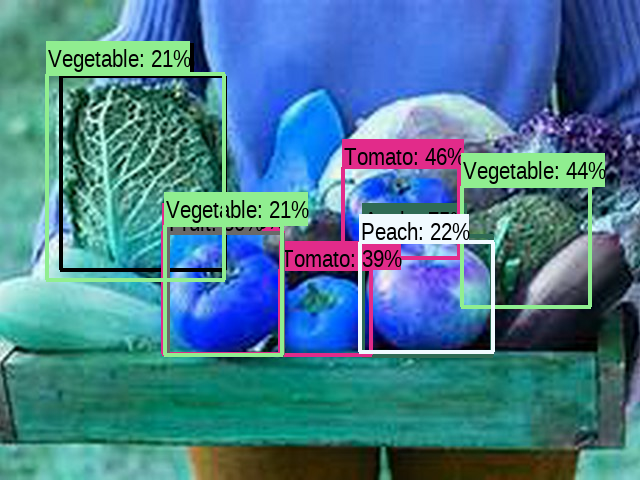

Inference time: 31.21983313560486


In [ ]:
image_urls = ["https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS1w-Bry-PX42X8tFiwIW9GER0t5kV8WDpGxA&usqp=CAU",
              "https://media.istockphoto.com/photos/group-of-pets-posing-around-a-border-collie-dog-cat-ferret-rabbit-picture-id1296353202?k=20&m=1296353202&s=612x612&w=0&h=-J5RllK3gwzLCkYbLUUPHmGuMxpneC7cfkAKFpfNfuk=",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTMwMb0vT4Tr6QoOmdrAmfEVEMw6zivkZuYWg&usqp=CAU",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5MCFoJbAuFjaf9AvarYyupDqUySsTFk3AIA&usqp=CAU",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRfujSuDb4x5Bt3fgt1CfN47SsGs0DwfclP6w&usqp=CAU",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWfAP_Qnnmqzx3HV_0Qf6w8e1z_3TPeQ1_IA&usqp=CAU",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSZh_hftblb3ljbg9PExv_SXsTJdVPBN97EKQ&usqp=CAU",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTk1d0gvzG9iTegWSFlrWMN2EM96Dk0p4d1Ww&usqp=CAU",
              "https://tse3.mm.bing.net/th?id=OIP.MPL8zIhA6zudsD0_qzCK4gHaE8&pid=Api&P=0&w=264&h=176",
              "https://tse2.mm.bing.net/th?id=OIP.XmeT2ifY9Exutk60RNXpogHaD4&pid=Api&P=0&w=330&h=172"]
  

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)
  
for i in range(10):
  detect_img(image_urls[i])
